# Detector de Noticias Falsas

**Resumen:** Este cuaderno pretende dar una breve visión general de cómo realizar la clasificación de textos utilizando Naive Bayes.

Utilizaremos un conjunto de datos llamado "Noticias Falsas" publicado en Kaggle https://www.kaggle.com/datasets/arseniitretiakov/noticias-falsas-en-espaol

Vamos a importar algunos paquetes necesarios antes de empezar a trabajar con el dataset que consiste en aproximadamente 2000 artículos de noticias, que fueron etiquetados como True y False.

Nuestro objetivo en este cuaderno es explorar el proceso de entrenamiento y prueba de un clasificador de texto para este problema, utilizando este conjunto de datos y un algoritmo implementado con sklearn.

Vamos a importar algunos paquetes necesarios antes de comenzar nuestro trabajo

# Importar Librerías

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # pandas para trabajar arhivos CSV

# matplotlib librería de desarrollar gráficas
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# importar librerías para la extracción de características 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# pre-procesarmiento de texto
import string
import re

# importar el clasificador desde sklearn
from sklearn.naive_bayes import MultinomialNB

# importar las métricas de evauación
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# importar la librería para separar nuestros datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

#importar librería para obtener las stopwords y trabajar con textos
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

wordnet = WordNetLemmatizer()
regex = re.compile('[%s]' % re.escape(string.punctuation))

In [10]:
#Descargar Stopwords en español
#Palabras habituales que no aportan significado (stop-words)
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stopword_es = set(nltk.corpus.stopwords.words('spanish'))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Función para evaluar los modelos

In [11]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

### Cargar y explorar los datos de entrenamiento 

In [27]:
true = pd.read_csv(r"/content/onlytrue1000.csv")
fake = pd.read_csv(r"/content/onlyfakes1000.csv")

# Asignamos primero las etiquetas de clase en variables de resultado binarias por comodidad. 1 para Real, y 0 para Falsas
true["class"] = 1
fake["class"] = 0

true["etiqueta"] = "Real"
fake["etiqueta"] = "Falsa"

our_data = pd.concat([true,fake])

our_data = shuffle(our_data)

our_data.rename(columns = {'text':'Text'}, inplace = True)

our_data.head()


,Text,class,etiqueta
303,"El pensamiento feminista, que nació con la nob...",0,Falsa
253,El Día Internacional contra la Violencia de Gé...,0,Falsa
696,"PERIODISTA ""Que piensas sobre la petición que ...",0,Falsa
445,El PSN critica que se pida el cierre de la cen...,1,Real
268,Continúan las tareas de rescate de una treinte...,1,Real


In [14]:
our_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 475 to 39
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2000 non-null   object
 1   class   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [15]:
#Validamos si tenemos valores nulos o faltantes
our_data.isna().sum()

Text     0
class    0
dtype: int64

In [16]:
#Observamos si existe algún desbalanceo en nuetros datos 
display(our_data.shape) #Número de files y columnas en nuestro dataset
our_data["class"].value_counts()/our_data.shape[0] # Distribucion de las etiquetas a predecir de nuestro dataset

(2000, 2)

0    0.5
1    0.5
Name: class, dtype: float64

**Covertimos la columna de etiqueta de clases a variable categórica**

Una variable categórica es aquella que permite clasificar una serie de datos por medio de valores fijos asociados a una cualidad o categoría concreta. La variable categórica, a diferencia de las variables cardinales o continuas (que permiten cálculos numéricos), clasifica a los individuos o casos.

In [17]:
our_data["class"] = pd.Categorical(our_data["class"])
our_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 475 to 39
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Text    2000 non-null   object  
 1   class   2000 non-null   category
dtypes: category(1), object(1)
memory usage: 33.3+ KB


Validamos cuantas observaciones tenemos por cada categoría

In [18]:
our_data["class"].value_counts()

0    1000
1    1000
Name: class, dtype: int64

# EDA (Análisis Exploratorio de Datos)

## 1 .- Preprocesamiento de Texto

Los pasos típicos consisten en la tokenización, convertir a minúsculas, la eliminación de stopwords, signos de puntuación, etc., y la vectorización. 

También se pueden llevar a cabo otros procesos, como el stemming o la lematización. 

En este caso, estamos realizando los siguientes pasos: eliminación de signos puntuación, números y stopwords. Para este ejemplo utilizamos las stopword de la librería NLTK, a veces, se necesitan listas de palabras reservadas personalizadas en función de la tarea.

In [19]:
#Función para eliminar las tildes
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

#función para limpiar texto
def limpiar_texto(line_from_column):    
    tokenized_doc = word_tokenize(line_from_column)
    
    new_review = []
    for token in tokenized_doc:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_review.append(new_token)
    
    new_term_vector = []
    for word in new_review:
        if not word in stopword_es:
            new_term_vector.append(normalize(word.lower()))
    
    final_doc = []
    for word in new_term_vector:
        final_doc.append(wordnet.lemmatize(word))
    
    return ' '.join(final_doc)

In [50]:
#Limpiando texto
our_data['clean_text'] = our_data['Text'].apply(limpiar_texto)

#texto limpio
our_data.head(2)

,Text,class,etiqueta,clean_text,text_len,text_word_count
303,"El pensamiento feminista, que nació con la nob...",0,Falsa,el pensamiento feminista nacio noble justa fin...,188,26
253,El Día Internacional contra la Violencia de Gé...,0,Falsa,el dia internacional violencia genero basa gra...,191,28


In [49]:
#Hacemos un conteo de palabras y frases
our_data["text_len"] = our_data["clean_text"].astype(str).map(len)
our_data["text_word_count"] = our_data["clean_text"].map(lambda x: len(str(x).split()))

In [45]:
#Función para obtener la frecuencia de palabras

def get_top_n_words(corpus, n=None):
 
 corpus_fake = corpus[our_data["class"] == 0].astype(str)
 corpus_true = corpus[our_data["class"] == 1].astype(str)
 
 vec = CountVectorizer(stop_words = stopword_es).fit(corpus_fake)
 bag_of_words = vec.transform(corpus_fake)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq_fake = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq_fake =sorted(words_freq_fake, key = lambda x: x[1], reverse=True)
 
 vec = CountVectorizer(stop_words = stopword_es).fit(corpus_true)
 bag_of_words = vec.transform(corpus_true)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq_true = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq_true =sorted(words_freq_true, key = lambda x: x[1], reverse=True)
 
 df_fake = pd.DataFrame(words_freq_fake[:n],columns = ["text", "count"])
 df_true = pd.DataFrame(words_freq_true[:n],columns = ["text", "count"])
 
 fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
 ax1.bar(df_fake["text"], df_fake["count"])
 ax1.set_xticklabels(df_fake["text"])
 ax1.set(xlabel="Top 10 de términos más frecuentes en noticias falsas", ylabel="count")
 ax2.bar(df_true["text"], df_true["count"])
 ax2.set_xticklabels(df_true["text"])
 ax2.set(xlabel="Top 10 de términos más frecuentes en noticias verdaderas", ylabel="count")
 plt.suptitle("Comparación de los términos más repetidos en las noticias (falsas/verdaderas)")
 
 plt.show()

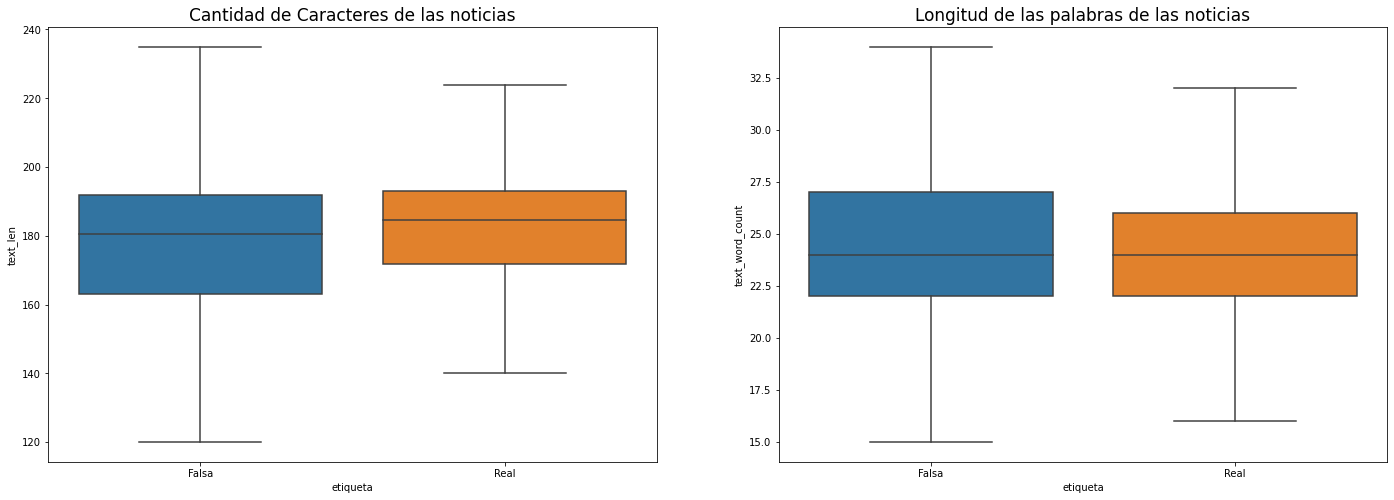

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(24,8))
sns.boxplot(y="text_len", x= "etiqueta", data=our_data, orient="v" , ax=axes[0], showfliers = False)
axes[0].set_title("Cantidad de Caracteres de las noticias", fontsize=17)

sns.boxplot(y="text_word_count", x= "etiqueta", data=our_data, orient="v" , ax=axes[1], showfliers = False)
axes[1].set_title("Longitud de las palabras de las noticias", fontsize=17)


plt.show()

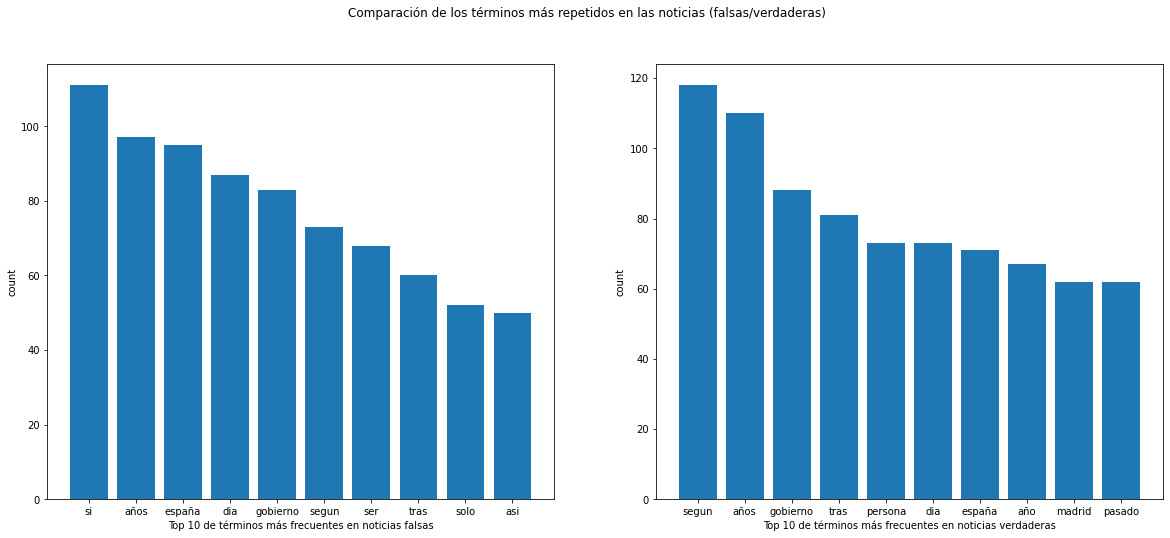

In [46]:
get_top_n_words(corpus=our_data["clean_text"], n=10)

# Modelado

Ahora estamos listos para desarrollar un modelo de clasificación.

Pasos:

1. Dividir los datos en conjuntos de entrenamiento y de prueba (75% de entrenamiento, 25% de prueba)    
2. Extraer las características de los datos de entrenamiento utilizando CountVectorizer y TfidfVectorizer. 
3. Transforme los datos de prueba en el mismo vector de características que los datos de entrenamiento.  
4. Entrenar el clasificador  
5. Evaluar el clasificador  

In [117]:
# Separamos en entrenamiento y prueba
X = our_data['clean_text'] # la columna que contiene el texto donde vamos a entraer las características
y = our_data["class"] # la columna donde vamos a aprender a clasificar  

# Separar X, y en datasets de entrenamiento prueba. Por defecto se usa el 75% para entrenar y el 25% para pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Datos de Entrenamiento:", X_train.shape, y_train.shape)
print("Datos de Prueba:",X_test.shape, y_test.shape)

Datos de Entrenamiento: (1500,) (1500,)
Datos de Prueba: (500,) (500,)


# ¿ Cómo extraer las características de un texto ?
Para este ejemplo vamos a utilizar dos técnicas:

* CountVectorizer
* TfidfVectorizer

# CountVectorizer
CountVectorizer es una gran herramienta proporcionada por la biblioteca scikit-learn en Python.

Se utiliza para transformar un texto dado en un vector sobre la base de la frecuencia(conteo) de cada palabra que aparece en todo el texto.

Esto es útil cuando tenemos varios textos de este tipo y deseamos convertir cada palabra de cada texto en vectores(para usar en análisis de texto).

CountVectorizer crea una matriz en la que cada palabra única está representada por una columna de la matriz, y cada muestra de texto del documento es una fila en la matriz. 

El valor de cada celda no es más que el recuento de la palabra en esa muestra de texto en particular. 

https://es.acervolima.com/uso-de-countvectorizer-para-extraer-caracteristicas-de-texto/

In [118]:
# Vectorizar los datasets de entrenamiento y prueba
vect = CountVectorizer() # instantiate a vectoriezer

X_train_dtm = vect.fit_transform(X_train)# utilizarlo para extraer características de los datos de entrenamiento

# transformar los datos de prueba (utilizando las características de los datos de entrenamiento)
X_test_dtm = vect.transform(X_test)

# dimensiones del dataset de prueba y entrenamiento
print(X_train_dtm.shape, X_test_dtm.shape) 

(1500, 11090) (500, 11090)


# TF-IDF

Utilizar simplemente un conteo de cuantas veces aparece una palabra no refleja realmente la importancia de esa palabra en un documento. 

Por ejemplo, si una palabra está presente con frecuencia en todos los documentos de un corpus, la cantidad de apariciones en diferentes documentos no es útil para discriminar entre diferentes documentos.

En cambio, si una palabra sólo está presente en unos pocos documentos, su valor de recuento en esos documentos puede ayudar a discriminarlos del resto de los documentos. Así pues, la importancia de una palabra, es decir, su valor de característica, para un documento no sólo depende de la frecuencia con la que está presente en ese documento, sino también de su presencia global en el corpus. Esta noción de importancia de una palabra en un documento se recoge en un esquema, conocido como esquema de ponderación de frecuencia de términos-frecuencia inversa de documentos (tf-idf ).

https://iksinc.online/tag/tfidfvectorizer/

In [119]:
# Vectorizar los datasets de entrenamiento y prueba
n_features = 15000
vect_tfidf = TfidfVectorizer(max_df=0.90, min_df=2, max_features=n_features)

X_train_dtm_tfidf = vect_tfidf.fit_transform(X_train) # utilizarlo para extraer características de los datos de entrenamiento

# transformar los datos de prueba (utilizando las características de los datos de entrenamiento)
X_test_dtm_tfidf = vect_tfidf.transform(X_test)

print(X_train_dtm_tfidf.shape, X_test_dtm_tfidf.shape)
# dimensiones del dataset de prueba y entrenamiento

(1500, 4293) (500, 4293)


# Modelando los datos  
Para clasificar las noticias (Fake, Real) vamos a utilizar un modelo de Naive Bayes*(se puedene probar otros modelos y técnicas)* y para extraer las características de los textos se implementarán dos estrategias un CountVectorizer y un TfidfVectorizer.

# CountVectorizer

In [120]:
#Entrenar el clasificador y predecir para los datos de prueba
nb = MultinomialNB() #instanciamos un modelo de Naive Bayes 
nb.fit(X_train_dtm, y_train) #entrenamos el modelo

y_pred_class = nb.predict(X_test_dtm) # predecir si una noticia es falsa o no sobre el dataset X_test_dtm

Accuracy:  0.794
ROC_AOC_Score:  0.8644557059465006


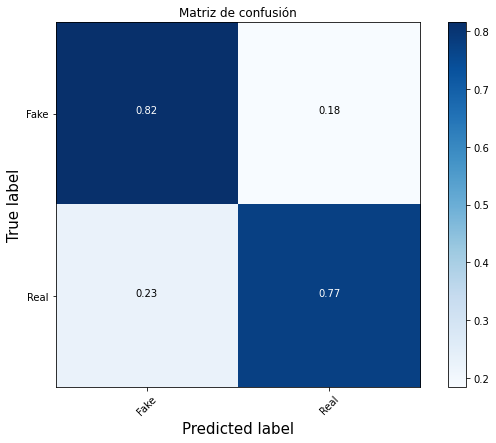

In [121]:
# Evaluar el modelo utilizando varias métricas
# Precisión:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# imprimi la matriz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Fake','Real'],normalize=True,
                      title='Matriz de confusión')

# calcular el AUC: El área bajo la curva (AUC) da una idea de la eficacia del modelo:
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

# Mulinomial Tfidf Vectorizer

In [122]:
# Step 3: Train the classifier and predict for test data
nb_tfidf = MultinomialNB() # instantiate a Multinomial Naive Bayes model
nb_tfidf.fit(X_train_dtm_tfidf, y_train) # train the model(timing it with an IPython "magic command")

y_pred_class_tfidf = nb_tfidf.predict(X_test_dtm_tfidf) # make class predictions for X_test_dtm

Accuracy:  0.778
ROC_AOC_Score:  0.8491083456283277


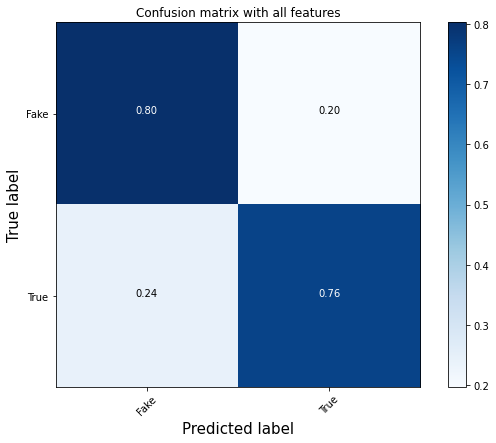

In [123]:
# Step 4: Evaluate the classifier using various measures
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class_tfidf))
    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class_tfidf)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Fake','True'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob_tfidf = nb_tfidf.predict_proba(X_test_dtm_tfidf)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob_tfidf))

# Vamos a clasificar algunas noticias nuevas

In [124]:
#cargamos el dataframe con noticias de prueba
test = pd.read_csv("test.csv")

In [126]:
#limpiamos el texto
test["clean"]= test['text'].apply(limpiar_texto)

In [127]:
test.head(2)

,title,text,clean
0,Podemos estudia en su programa playas para muj...,Spanish nationalism rabid that a Catalan compa...,spanish nationalism rabid that catalan company...
1,Alemania va a quitar los hijos a los padres po...,"Su amante, llamó al marido llorando y le contó...",su amante llamo marido llorando conto pasando ...


# Clasificar con CountVectorizer que nos dio mejores resultados

In [128]:
test_dtm = vect.transform(test["clean"])# use it to extract features from training data

In [129]:
y_pred_test = nb.predict(test_dtm) # make class predictions for test_dtm

In [130]:
# convert label to Fake - Real
test['class'] = pd.Series(y_pred_test).map({1:"Real", 0:"Falso"}) # True 1, Falsa 0. 

In [133]:
#Cuántas noticias clasificó de cada clase
test["class"].value_counts()

Falso    205
Real     195
Name: class, dtype: int64

In [135]:
#Veamos algunas noticias falsas
test[test["class"] == "Falso"][:5]

,title,text,clean,class
0,Podemos estudia en su programa playas para muj...,Spanish nationalism rabid that a Catalan compa...,spanish nationalism rabid that catalan company...,Falso
1,Alemania va a quitar los hijos a los padres po...,"Su amante, llamó al marido llorando y le contó...",su amante llamo marido llorando conto pasando ...,Falso
2,Valencia multará los balcones con banderas por...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...,suben la pensiones 1 euro y suben el recibo de...,Falso
3,Un directivo de Hazte Oír se besa con una muje...,"Suecia está haciendo un experimento, ha reduci...",suecia haciendo experimento reducido jornada l...,Falso
4,Iglesias y Montero se compran también un apart...,Suecia sigue avanzando hacia su islamización. ...,suecia sigue avanzando hacia islamizacion segu...,Falso


In [137]:
#Veamos algunas noticias verdaderas
test[test["class"] == "Real"][:5]

,title,text,clean,class
63,INFORME ESPECIAL: la última inversión de Josef...,Un vecino de 24 años de Zamora fue detenido la...,un vecino 24 años zamora detenido noche sabado...,Real
100,Entra en prisión el joven condenado a 6 años p...,La cuenta atrás terminó diez minutos antes de ...,la cuenta atras termino diez minutos siete tar...,Real
105,NaN,1200 cotxes col·lapsen ara mateix els accessos...,1200 cotxes col·lapsen ara mateix el accessos ...,Real
125,NaN,Los servicios de emergencia no han podido lleg...,los servicios emergencia podido llegar tiempo ...,Real
129,NaN,De cuando John Lennon & Ernesto “Che” Guevara ...,de john lennon ernesto “ che ” guevara hiciero...,Real


In [132]:
#guardamos el modelo
#guardamos el vectorizador de texto
import pickle

pickle.dump(nb, open('model.pkl', 'wb')) #exportar modelo
pickle.dump(vect, open('carecteristicas.pkl', 'wb')) #exportar feature extraction
